# 🤪 Variational Autoencoders - CelebA Faces

In [21]:
working_dir = "/home/mary/work/repos/generative_deep_Learning_2nd_edition_pytorch"
exp_dir = working_dir + "/notebooks/03_vae/03_vae_faces/"

In [22]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Add the path to the notebooks folder
notebooks_path = os.path.abspath(working_dir)
if notebooks_path not in sys.path:
    sys.path.append(notebooks_path)

utils_path = os.path.abspath(exp_dir)
if utils_path not in sys.path:
    sys.path.append(utils_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import torchvision
from torchvision import transforms
from torchvision import datasets
import torch
from notebooks.utils import display

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchinfo import summary

import torch.utils
import torch.utils.data
import math
import numpy as np
from scipy.stats import norm

import PIL
import pandas as pd

from vae_utils import get_vector_from_label, add_vector_to_images, morph_faces

## 0. Parameters <a name="parameters"></a>

In [64]:
IMAGE_SIZE = 32
CHANNELS = 3
BATCH_SIZE = 128
NUM_FEATURES = 128
Z_DIM = 200
LEARNING_RATE = 0.0005
EPOCHS = 10
BETA = 2000
LOAD_MODEL = False
TRAIN_SPLIT = 0.8

## 1. Prepare the data <a name="prepare"></a>

In [65]:
data_dir = working_dir + "/data"
dataset_dir = data_dir + "/celeba-dataset"

In [66]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Padding (left, top, right, bottom)
    transforms.ToTensor()
    
])

dataset = datasets.ImageFolder(dataset_dir, transform=transform)
train_size = int(TRAIN_SPLIT * len(dataset))
test_size = int(len(dataset) - train_size)

train_data, test_data =  torch.utils.data.random_split(dataset, [train_size, test_size])

train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

In [67]:
print(f"training data size= {len(train_data)}")
print(f"test data size= {len(test_data)}")

training data size= 162079
test data size= 40520


In [68]:
dataiter = iter(train_data_loader)
images, lables = next(dataiter)

print(type(images))
print(images.shape)

TypeError: 'torch.dtype' object is not callable

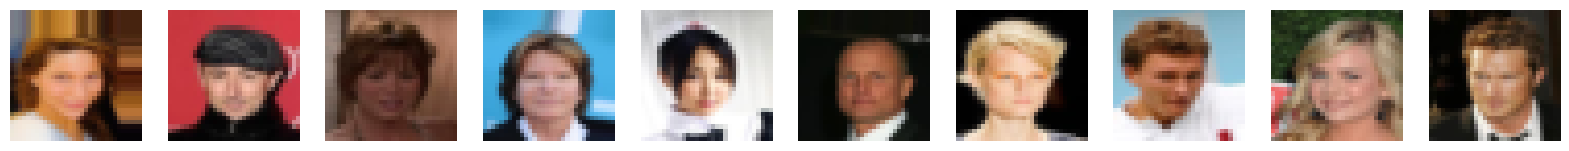

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
display(images[:10])
print(lables[:10])

## 2. Build the variational autoencoder <a name="build"></a>

In [ ]:
class Sampling(nn.Module):
    def forward(self, inputs):
        z_mean, z_log_var = inputs
        batch = z_mean.shape[0]
        dim = z_mean.shape[1]
        device = z_mean.device
        epsilon = torch.randn(size=(batch, dim)).to(device)
        sample = z_mean + torch.exp(0.5* z_log_var) * epsilon
        return sample

In [ ]:
class Encoder(nn.Module):

    def __init__(self, image_size, channels, feature_num):
        super().__init__()

        p = self._get_padding_size(image_size, 2, 3)
        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=feature_num, kernel_size=3, stride=2, padding=p)
        self.bn1 = nn.BatchNorm2d(num_features=feature_num)
        
        p = self._get_padding_size(image_size/2, 2, 3)
        self.conv2 = nn.Conv2d(in_channels=feature_num, out_channels=feature_num, kernel_size=3, stride=2, padding=p)
        self.bn2 = nn.BatchNorm2d(num_features=feature_num)

        p = self._get_padding_size(image_size/4, 2, 3)
        self.conv3 = nn.Conv2d(in_channels=feature_num, out_channels=feature_num, kernel_size=3, stride=2, padding=p)
        self.bn3 = nn.BatchNorm2d(num_features=feature_num)

        p = self._get_padding_size(image_size/8, 2, 3)
        self.conv4 = nn.Conv2d(in_channels=feature_num, out_channels=feature_num, kernel_size=3, stride=2, padding=p)
        self.bn4 = nn.BatchNorm2d(num_features=feature_num)

        self.shape_before_flattening = (feature_num, image_size/16, image_size/16)

        self.fc_mean = nn.Linear(in_features=int(math.prod(self.shape_before_flattening)), out_features=Z_DIM)
        self.fc_log_var = nn.Linear(in_features=int(math.prod(self.shape_before_flattening)), out_features=Z_DIM)

        self.sampling_layer = Sampling()

    def get_shape_before_flattening(self):
        return tuple(map(int, self.shape_before_flattening))
    
    @staticmethod
    def _get_padding_size(input_w, stride, kernal_size):
        p = ((input_w /2) - 1) * stride
        p = (p - input_w) + kernal_size
        p = math.ceil(p/2)

        return p
    
    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        # # flatten
        x = x.view(x.shape[0], -1)
        
        z_mean = self.fc_mean(x)
        z_log_var = self.fc_mean(x)

        z = self.sampling_layer((z_mean, z_log_var))
        
        return z_mean, z_log_var, z

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
endocde = Encoder(IMAGE_SIZE, CHANNELS, NUM_FEATURES).to(device)

print(endocde)


Encoder(
  (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc_mean): Linear(in_features=512, out_features=200, bias=True)
  (fc_log_var): Linear(in_features=512, out_features=200, bias=True)
  (sampling_layer): Sampling()
)


In [ ]:
summary(endocde, (1, CHANNELS, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 200]                  102,600
├─Conv2d: 1-1                            [1, 128, 16, 16]          3,584
├─BatchNorm2d: 1-2                       [1, 128, 16, 16]          256
├─Conv2d: 1-3                            [1, 128, 8, 8]            147,584
├─BatchNorm2d: 1-4                       [1, 128, 8, 8]            256
├─Conv2d: 1-5                            [1, 128, 4, 4]            147,584
├─BatchNorm2d: 1-6                       [1, 128, 4, 4]            256
├─Conv2d: 1-7                            [1, 128, 2, 2]            147,584
├─BatchNorm2d: 1-8                       [1, 128, 2, 2]            256
├─Linear: 1-9                            [1, 200]                  102,600
├─Linear: 1-10                           [1, 200]                  (recursive)
├─Sampling: 1-11                         [1, 200]                  --
Total params: 652,560
Trainable params: 652,

In [ ]:
class Decoder(nn.Module):
    def __init__(self, shape_before_flatten, channels, feature_num):
        super().__init__()

        self.shape_before_flatten = shape_before_flatten

        self.fc1 = nn.Linear(in_features=Z_DIM, out_features=int(math.prod(self.shape_before_flatten)))
        self.bn_fc = nn.BatchNorm1d(num_features=int(math.prod(self.shape_before_flatten)))

        p = self._get_padding_size(self.shape_before_flatten[1], stride=2, kernaal_size=3)
        self.conv_trans1 = nn.ConvTranspose2d(in_channels=self.shape_before_flatten[0], out_channels=feature_num, 
                                              kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(num_features=feature_num)
        
        p = self._get_padding_size(self.shape_before_flatten[1]*2, stride=2, kernaal_size=3)

        self.conv_trans2 = nn.ConvTranspose2d(in_channels=feature_num, out_channels=feature_num, kernel_size=3, 
                                              stride=2, padding=p, output_padding=1)
        self.bn2 = nn.BatchNorm2d(num_features=feature_num)
        
        p = self._get_padding_size(self.shape_before_flatten[1]*4, stride=2, kernaal_size=3)
        self.conv_trans3 = nn.ConvTranspose2d(in_channels=feature_num, out_channels=feature_num, kernel_size=3,
                                              stride=2, padding=p, output_padding=1)
        self.bn3 = nn.BatchNorm2d(num_features=feature_num)

        p = self._get_padding_size(self.shape_before_flatten[1]*8, stride=2, kernaal_size=3)
        self.conv_trans4 = nn.ConvTranspose2d(in_channels=feature_num, out_channels=feature_num, kernel_size=3,
                                              stride=2, padding=p, output_padding=1)
        self.bn4 = nn.BatchNorm2d(num_features=feature_num)

        p = self._get_padding_size(self.shape_before_flatten[1]*16, stride=1, kernaal_size=3)
        self.conv_trans5 = nn.ConvTranspose2d(in_channels=feature_num, out_channels=channels, 
                                              kernel_size=3, stride=1, padding=1, output_padding=0)
        
    @staticmethod
    def _get_padding_size(input_w, stride, kernaal_size):
        p = ((input_w - 1) * stride) / 2
        p = p - input_w
        p = p + (kernaal_size / 2)
        p = p + 1/2
        return math.ceil(p)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn_fc(x)
        x = F.leaky_relu(x)
        c, w, h = self.shape_before_flatten
        x = x.view(-1, c, w, h)
        x = self.conv_trans1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x)
        x = self.conv_trans2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.conv_trans3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x)
        x = self.conv_trans4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x)
        x = self.conv_trans5(x)
        x = F.sigmoid(x)
        # Should we add sigmoid?

        return x

In [ ]:
shape_before_faltten = endocde.get_shape_before_flattening()
decoder = Decoder(shape_before_faltten, CHANNELS, NUM_FEATURES).to(device)
print(decoder)

Decoder(
  (fc1): Linear(in_features=200, out_features=512, bias=True)
  (bn_fc): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_trans1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_trans2): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_trans3): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_trans4): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_t

In [ ]:
summary(decoder, (1, Z_DIM,))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 3, 32, 32]            --
├─Linear: 1-1                            [1, 512]                  102,912
├─BatchNorm1d: 1-2                       [1, 512]                  1,024
├─ConvTranspose2d: 1-3                   [1, 128, 4, 4]            147,584
├─BatchNorm2d: 1-4                       [1, 128, 4, 4]            256
├─ConvTranspose2d: 1-5                   [1, 128, 8, 8]            147,584
├─BatchNorm2d: 1-6                       [1, 128, 8, 8]            256
├─ConvTranspose2d: 1-7                   [1, 128, 16, 16]          147,584
├─BatchNorm2d: 1-8                       [1, 128, 16, 16]          256
├─ConvTranspose2d: 1-9                   [1, 128, 32, 32]          147,584
├─BatchNorm2d: 1-10                      [1, 128, 32, 32]          256
├─ConvTranspose2d: 1-11                  [1, 3, 32, 32]            3,459
Total params: 698,755
Trainable params: 698,755
No

In [ ]:
class var_autoencoder(nn.Module):
    def __init__(self, image_size, channels, feature_num, log_dir="./log"):
        super().__init__()
        self.encoder = Encoder(image_size, channels, feature_num)
        shape_before_flatten = self.encoder.get_shape_before_flattening()
        self.decoder = Decoder(shape_before_flatten, channels, feature_num)

        # tensorboard writer
        self.writer_train = SummaryWriter(log_dir + "/train")
        self.writer_val = SummaryWriter(log_dir + "/val")
    
    def forward(self, x):
        z_mean, z_log_var, z = self.encoder(x)
        images = self.decoder(z)

        return z_mean, z_log_var, images
    
    def train_step(self, train_data_loader, optimizer):
        # training
        self.train()
        acc_loss, acc_rec_loss, acc_var_loss = 0, 0, 0


        for x_train, _ in train_data_loader:
            x_train = x_train.to(self.device)

            optimizer.zero_grad()

            z_mean, z_log_var, rec_images = self.forward(x_train)

            rec_loss = self.rec_loss_fn(rec_images, x_train)
            var_loss = self.var_loss_fn(z_mean, z_log_var)
            total_loss = (rec_loss * self.beta) + var_loss
            # total_loss = 100 *rec_loss + 0.002 * var_loss

            total_loss.backward()
            optimizer.step()

            acc_loss += total_loss.item()
            acc_rec_loss += rec_loss.item()
            acc_var_loss += var_loss.item()
        
        return({"rec_loss": acc_rec_loss/len(train_data_loader), 
                "var_loss": acc_var_loss/len(train_data_loader), 
                "total_loss": acc_loss/len(train_data_loader)})
            
    def eval_step(self, test_data_loader):
        # evaluation
        self.eval()

        eval_acc_loss, eval_acc_rec_loss, eval_acc_var_loss = 0, 0, 0
        with torch.no_grad():
            for x_test, _ in test_data_loader:
                x_test = x_test.to(self.device)

                z_mean, z_log_var, rec_images = self.forward(x_test)

                
                eval_rec_loss = self.rec_loss_fn(rec_images, x_test)
                eval_var_loss = self.var_loss_fn(z_mean, z_log_var)
                eval_total_loss = (eval_rec_loss * self.beta) + eval_var_loss
                # eval_total_loss = 100 *eval_rec_loss + 0.002 * eval_var_loss
                
                eval_acc_rec_loss += eval_rec_loss.item()
                eval_acc_var_loss += eval_var_loss.item()
                eval_acc_loss += eval_total_loss.item()

        return({"rec_loss": eval_acc_rec_loss/len(test_data_loader), 
                "var_loss": eval_acc_var_loss/len(test_data_loader), 
                "total_loss": eval_acc_loss/len(test_data_loader)})

    def save_checkpoint(self, optimizer, epoch, loss, checkpoint_dir):
        checkpoint = {
            "epoch":epoch,
            "model_state_dict":self.state_dict(),
            "optimizer_state_dict":optimizer.state_dict(),
            "loss":loss
        }
        checkpoint_file = checkpoint_dir + f"/checkpoint_epoch_{epoch}.pth"
        torch.save(checkpoint, checkpoint_file)

    def fit(self, train_data_loader, test_data_loader, optimizer,
            rec_loss_fn, var_loss_fn, device, epochs=10, beta=500, checkpoint_dir="./checkpoint"):
        
        self.rec_loss_fn = rec_loss_fn
        self.var_loss_fn = var_loss_fn
        self.device = device
        self.beta = beta
        
        for i in range(epochs):

            train_losses = self.train_step(train_data_loader, optimizer)

            eval_losses = self.eval_step(test_data_loader)

            
            # log to tensor board
            # self.writer.add_scalar('rec_loss', {'train': train_losses['rec_loss'],
            #                                     'val':eval_losses['rec_loss'] }, global_step=i)
            self.writer_train.add_scalar("rec_loss",train_losses['rec_loss'], global_step=i)
            self.writer_train.add_scalar("kl_loss",train_losses['var_loss'], global_step=i)
            self.writer_train.add_scalar("total_loss",train_losses['total_loss'], global_step=i)
            
            self.writer_val.add_scalar("rec_loss", eval_losses['rec_loss'], global_step=i)
            self.writer_val.add_scalar("kl_loss", eval_losses['var_loss'], global_step=i)
            self.writer_val.add_scalar("total_loss", eval_losses['total_loss'], global_step=i)


            # save checkpoint
            self.save_checkpoint(optimizer, i, train_losses, checkpoint_dir)

            print(
                f"Epoch {i}/{epochs}: Training: rec_loss: {train_losses['rec_loss'] :.4f} "
                f"var_loss: {train_losses['var_loss']:.4f} "
                f"total_loss: {train_losses['total_loss']:.4f}"
            )
            
            print(
                f"Epoch {i}/{epochs}: Evaluation: rec_loss: {eval_losses['rec_loss']:.4f} "
                f"var_loss: {eval_losses['var_loss']:.4f} "
                f"total_loss: {eval_losses['total_loss'] :.4f}"
            )
            
            print()

In [ ]:
log_dir =  exp_dir + "/log"
os.makedirs(log_dir, exist_ok=True)

vae = var_autoencoder(IMAGE_SIZE, CHANNELS, NUM_FEATURES, log_dir=log_dir).to(device)
print(vae)

var_autoencoder(
  (encoder): Encoder(
    (conv1): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc_mean): Linear(in_features=512, out_features=200, bias=True)
    (fc_log_var): Linear(in_features=512, out_features=200, bias=True)
    (sampling_layer): Sampling()
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=200, out_features=512, bias=True)
    (bn_f

In [ ]:
def kl_loss(z_mean, z_log_var):
    B = z_mean.shape[0]
    loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    # get the mean loss
    loss = loss / B
    return loss


## 3. Train the variational autoencoder <a name="train"></a>

In [ ]:
learning_rate=LEARNING_RATE

In [ ]:
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [ ]:
reconstruction_loss_fn =  nn.BCELoss()
var_loss_fn = kl_loss

In [ ]:
checkpoint_dir =  exp_dir + "/checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)

vae.fit(train_data_loader=train_data_loader, test_data_loader=test_data_loader,
        optimizer=optimizer, rec_loss_fn=reconstruction_loss_fn, var_loss_fn=var_loss_fn, 
        device=device, epochs=EPOCHS, beta=BETA, checkpoint_dir=checkpoint_dir)

Epoch 0/10: Training: rec_loss: 0.5466 var_loss: 139.1975 total_loss: 11070.9393
Epoch 0/10: Evaluation: rec_loss: 0.5339 var_loss: 161.8145 total_loss: 10839.8811

Epoch 1/10: Training: rec_loss: 0.5261 var_loss: 164.8116 total_loss: 10686.0654
Epoch 1/10: Evaluation: rec_loss: 0.5225 var_loss: 166.0438 total_loss: 10615.7460

Epoch 2/10: Training: rec_loss: 0.5223 var_loss: 168.7077 total_loss: 10615.1981
Epoch 2/10: Evaluation: rec_loss: 0.5217 var_loss: 176.2836 total_loss: 10610.2955

Epoch 3/10: Training: rec_loss: 0.5199 var_loss: 172.0477 total_loss: 10570.8384
Epoch 3/10: Evaluation: rec_loss: 0.5185 var_loss: 173.9579 total_loss: 10543.9896

Epoch 4/10: Training: rec_loss: 0.5184 var_loss: 174.4948 total_loss: 10541.7423
Epoch 4/10: Evaluation: rec_loss: 0.5176 var_loss: 176.1510 total_loss: 10528.1904

Epoch 5/10: Training: rec_loss: 0.5173 var_loss: 176.0979 total_loss: 10522.4380
Epoch 5/10: Evaluation: rec_loss: 0.5159 var_loss: 175.8411 total_loss: 10493.0074

Epoch 6/10

In [ ]:
# save the trained models
model_dir = exp_dir + "/models"
os.makedirs(model_dir, exist_ok=True)

torch.save(vae.encoder.state_dict(), model_dir + "/encoder")
torch.save(vae.decoder.state_dict(), model_dir+"/decoder")
torch.save(vae.state_dict(), model_dir+"/vae")

## 3. Reconstruct using the variational autoencoder <a name="reconstruct"></a>

In [ ]:
n_to_predict = 5000
print(len(test_data))
test_iter = iter(test_data_loader)
example_images, example_lables = [], []

while (len(example_images)*BATCH_SIZE) < n_to_predict:
    test_images_batch, test_lables_batch = next(test_iter)
    example_images.append(test_images_batch)
    example_lables.append(test_lables_batch)

example_images = torch.stack(example_images)
w, h, c = example_images.shape[2:]
example_images = example_images.view(-1, w, h, c)

example_lables = torch.stack(example_lables).view(-1)

print(example_images.shape)
print(example_lables.shape)

40520
torch.Size([5120, 3, 32, 32])
torch.Size([5120])


In [ ]:
with torch.no_grad():
    vae.eval()
    z_mean, z_log_var, rec_images = vae.forward(example_images[0:20].to(device))

Example of real cloths


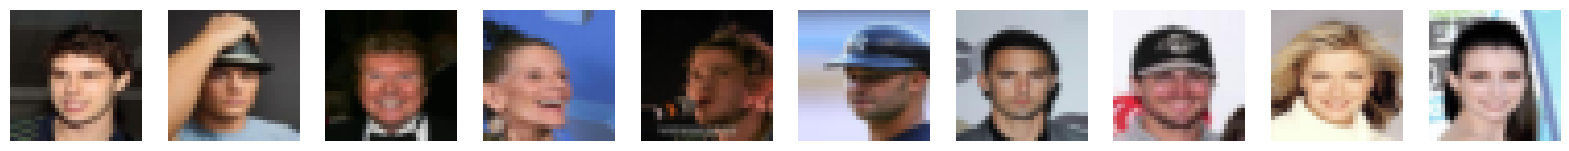

Example reconstrcuted images


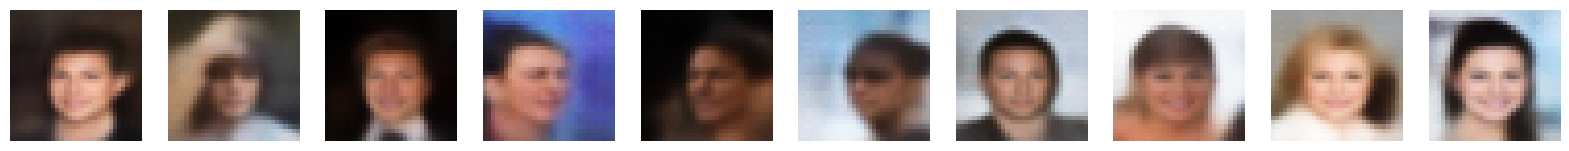

In [ ]:
print("Example of real cloths")
display(example_images)
print("Example reconstrcuted images")
display(rec_images)

In [ ]:
train_data_iter = iter(train_data_loader)
sample_train, _ = next(train_data_iter)

In [ ]:
with torch.no_grad():
    vae.eval()
    _, _, rec_example = vae.forward(sample_train[0:20].to(device))

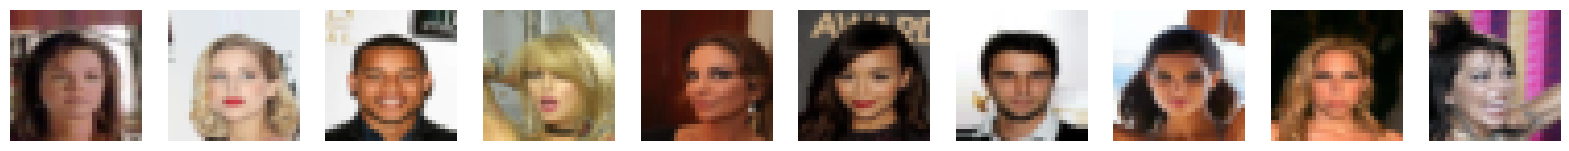

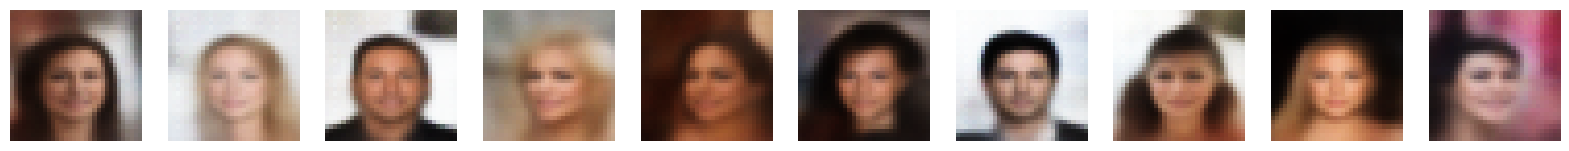

In [ ]:
display(sample_train)
display(rec_example)

## 4. Latent space distribution

In [ ]:
with torch.no_grad():
    vae.eval()
    z_mean, z_log_var, z = vae.encoder(example_images.to(device))

embeddings_np = z.to("cpu").detach().numpy()
print(embeddings_np[:10])

[[ 0.4409896   0.25929564 -0.15551886 ... -1.4102405   0.42418146
  -0.4510445 ]
 [ 1.3442078  -0.4031316  -2.1978335  ... -1.4504976  -0.75877994
   0.357745  ]
 [ 0.8127563   0.22120482 -0.7231462  ... -1.1920803  -0.82061017
  -0.32174742]
 ...
 [-0.8928797  -1.5707369   0.43410695 ...  3.6824532  -2.1581357
  -1.3730593 ]
 [-0.42403984 -1.3674203  -0.5528228  ...  0.8964195  -0.7794012
   0.13930973]
 [-0.6632986   1.7341686  -0.29539382 ...  0.9379277  -0.75987357
  -1.5775596 ]]


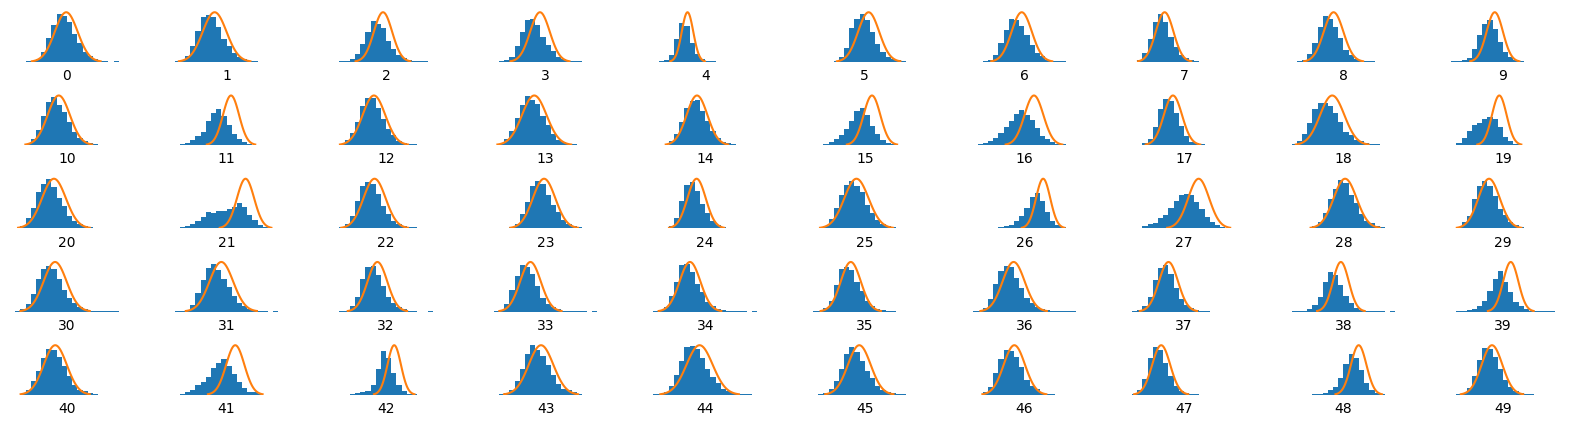

In [ ]:
x = np.linspace(-3, 3, 100)

fig = plt.figure(figsize=(20, 5))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i + 1)
    ax.hist(embeddings_np[:, i], density=True, bins=20)
    ax.axis("off")
    ax.text(
        0.5, -0.35, str(i), fontsize=10, ha="center", transform=ax.transAxes
    )
    ax.plot(x, norm.pdf(x))

plt.show()

## 5. Generate new faces <a name="decode"></a>

In [ ]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = torch.randn(size=(grid_width * grid_height, Z_DIM))

In [ ]:
# Decode the sampled points
type = example_images.dtype
with torch.no_grad():
    vae.eval()
    reconstructions = vae.decoder.forward(z_sample.to(device).to(type)).permute(0, 2, 3,1).to("cpu").detach().numpy()

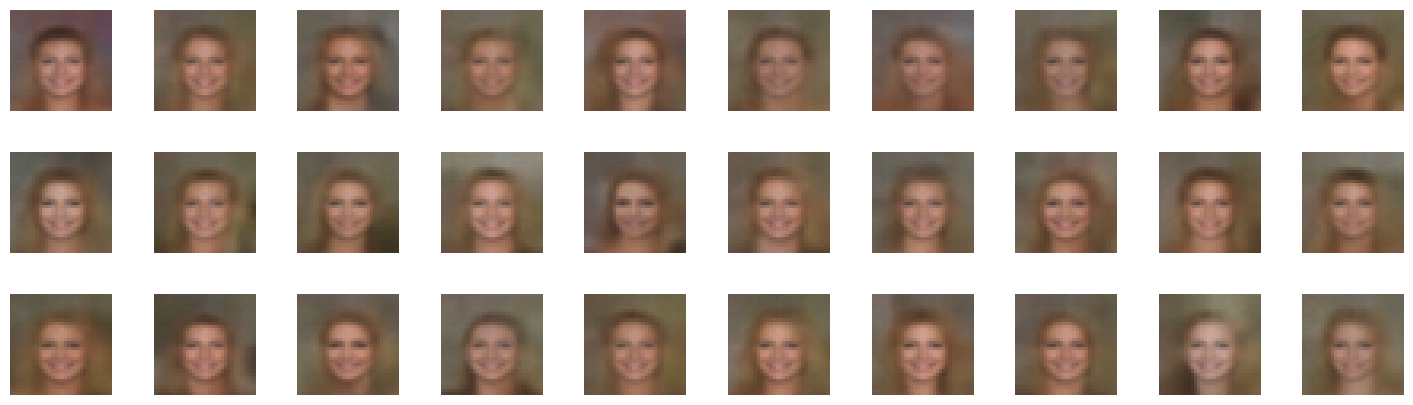

In [ ]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :])

## 6. Manipulate the images <a name="manipulate"></a>

Implement a data loader with custom labels

In [ ]:
image_dir = dataset_dir + "/img_align_celeba/img_align_celeba/"
labels_file = dataset_dir + "/list_attr_celeba.csv"

In [ ]:
class ImageWLabelsDataset(torch.utils.data.Dataset):
    
    def __init__(self, images_dir, images_list, labels_list, transforms):
        self.images_dir = images_dir
        self.labels = labels_list
        self.transforms = transforms
        self.img_files = images_list
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = PIL.Image.open(self.images_dir + self.img_files[idx]).convert("RGB")
        label = torch.tensor(self.labels[idx])

        if self.transforms:
            image = self.transforms(image)
        
        return(image, label)


Load the dataset with labels

In [ ]:
attributes = pd.read_csv(labels_file)
print(attributes.columns)
attributes.head()

Index(['image_id', '5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',
       'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose',
       'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows',
       'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair',
       'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open',
       'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin',
       'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns',
       'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings',
       'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace',
       'Wearing_Necktie', 'Young'],
      dtype='object')


,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [ ]:
LABEL = "Blond_Hair"
IMAGE_HEAD = "image_id"
attributes[LABEL].head()

image_list = attributes[IMAGE_HEAD].to_list()
labels_list = attributes[LABEL].to_list()

print(len(image_list), len(labels_list))
print(image_list[0], labels_list[0])

202599 202599
000001.jpg -1


In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
    transforms.ToTensor()
    
])

dataset_wlabels = ImageWLabelsDataset(images_dir=image_dir, images_list=image_list, 
                              labels_list=labels_list, transforms=transform)


train_size = int(TRAIN_SPLIT * len(dataset))
test_size = int(len(dataset) - train_size)

train_data_wlabels, test_data_wlabels =  torch.utils.data.random_split(dataset_wlabels, [train_size, test_size])

train_data_loader_wlabels = DataLoader(train_data_wlabels, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

test_data_loader_wlabels = DataLoader(test_data_wlabels, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

Find the vector for the required attribuite

In [ ]:
# Find the attribute vector
attribute_vec = get_vector_from_label(train_data_loader_wlabels, vae, Z_DIM, device=device, type=type)


distance change =  5.488919258117676
distance change =  -0.616385
distance change =  -0.15693998
distance change =  -0.10289526
distance change =  0.0006508827
distance change =  -0.17924166
distance change =  -0.14957094
distance change =  0.009704113
distance change =  -0.0034971237
distance change =  -0.03088522
distance change =  0.013131142
distance change =  0.041535378
distance change =  -0.105831146
distance change =  -0.03071785
distance change =  -0.08515835
distance change =  0.031157494
distance change =  -0.03356886
distance change =  -0.0016937256
distance change =  -0.0057663918
distance change =  0.020014286
distance change =  -0.013893127
distance change =  -0.009063721
distance change =  -0.0112166405
distance change =  -0.01279211
distance change =  0.007441044
distance change =  0.03214836
distance change =  0.022695541
distance change =  -0.002521515
distance change =  -0.033185482
distance change =  0.009007454
distance change =  -0.022810936
distance change =  0.

/home/mary/work/repos/generative_deep_Learning_2nd_edition_pytorch/notebooks/03_vae/03_vae_faces/vae_utils.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  torch.tensor([changed_z_point], device=device, dtype=type)


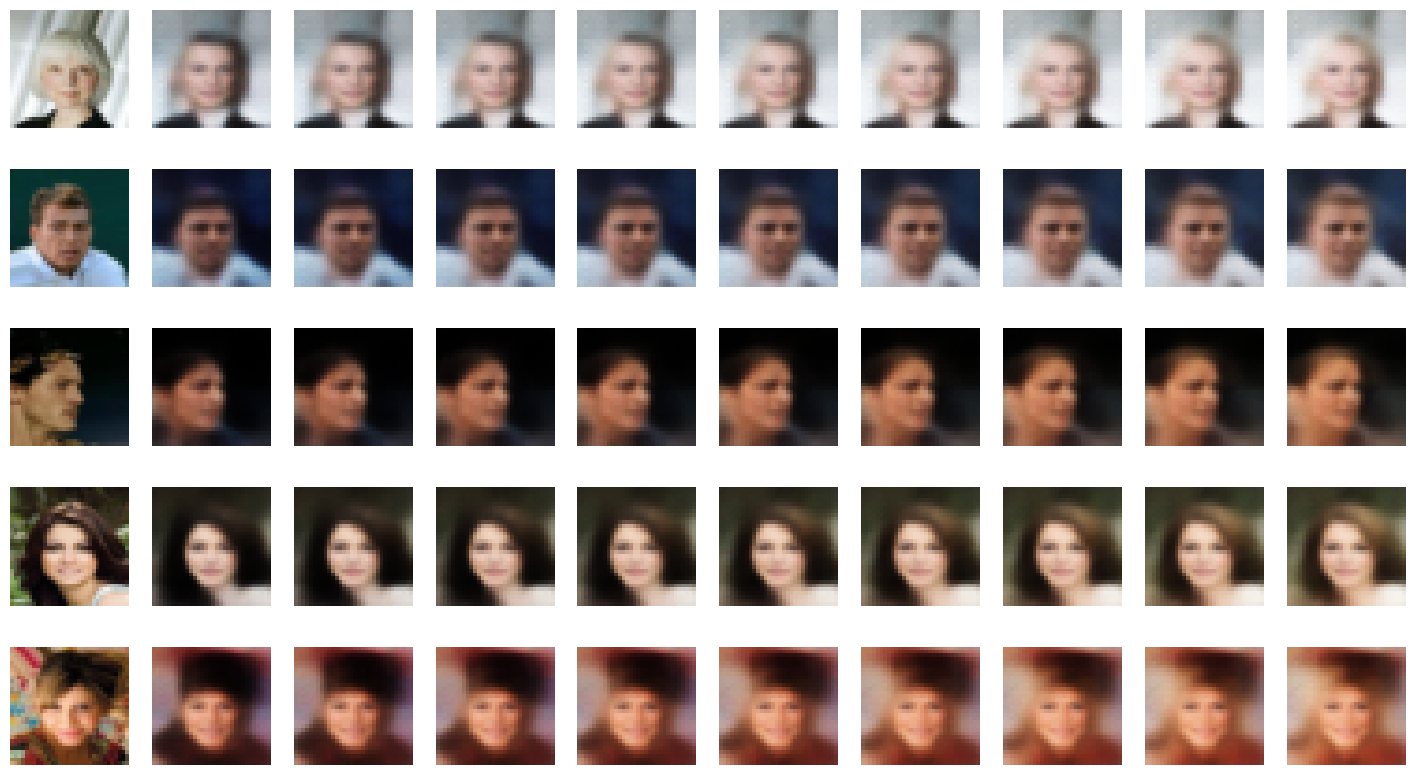

In [ ]:
add_vector_to_images(train_data_loader_wlabels, vae, feature_vec=attribute_vec , device=device, type=type)

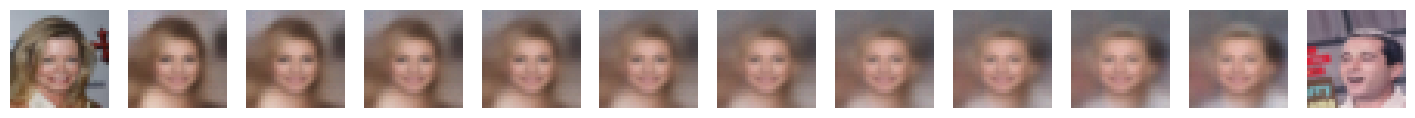

In [ ]:
morph_faces(train_data_loader_wlabels, vae, device=device, type=type)